In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# Download the wine dataset from the UCI Machine Learning Repository
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)

In [3]:
# Show the first five rows of the dataset
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# Show the shape of the dataset
df_wine.shape

(178, 14)

In [5]:
# Splitting the dataset into features and target variable
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values # Target variable is the first column

In [6]:
# Splitting the dataset into training and test sets
# stratify=y makes sure that the training and test datasets have the same class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) # 30% test data

In [7]:
# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# Compute one mean vector for each label
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



In [9]:
# Compute the within-class scatter matrix
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [ ]:
# Calculate the between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T)

print('Between-class scatter matrix: ' f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


In [11]:
# Calculate the eigenvalues and eigenvectors of the matrix 𝑺𝑊−1·𝑺𝐵 :
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [14]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059941
172.76152218979394
2.927452713255748e-14
2.927452713255748e-14
1.480381625339196e-14
1.3533650132059972e-14
1.3533650132059972e-14
1.0917306164816297e-14
9.463628713182403e-15
8.596407573242877e-15
4.528090986998065e-15
4.528090986998065e-15
3.533213355930368e-15


In [15]:
# Construct the projection matrix 
# In this case, we will reduce the high-dimensional feature space to a 2-dimensional feature subspace
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.14808266  0.40918668]
 [ 0.09076942  0.15765978]
 [-0.01678204  0.35371242]
 [ 0.14840098 -0.32231568]
 [-0.0163456   0.08168973]
 [ 0.19130756 -0.08419165]
 [-0.73377547 -0.28234956]
 [-0.07501992  0.01015645]
 [ 0.00184929 -0.09065024]
 [ 0.29402743  0.2152308 ]
 [-0.03282632 -0.27470975]
 [-0.35466909  0.01243875]
 [-0.39151562  0.59578685]]


In [16]:
# Transform the first element of the training dataset using the projection matrix
X_train_std[0].dot(w)

array([1.31763265, 0.64040545])

In [17]:
# Transform the entire training dataset using the projection matrix
X_train_lda = X_train_std.dot(w)

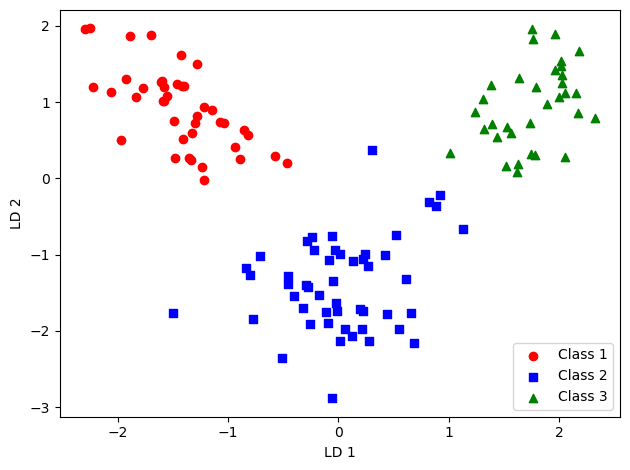

In [18]:
# Visualize the transformed  training dataset in a two-dimensional scatterplot
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [20]:
# Auxiliar function to plot the decision regions
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

/home/lbote/anaconda3/envs/mi_entorno/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


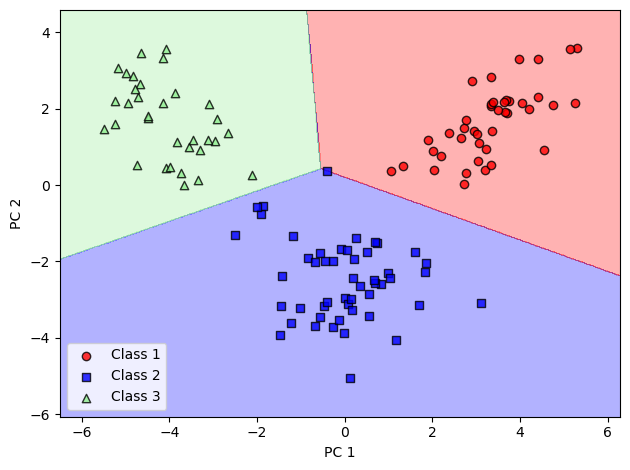

In [22]:
# scikit-learn
# Initializing the LDA transformer
lda = LDA(n_components=2)

# Initializing the logistic regression estimator:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs') # ovr = One-vs-Rest, lbfgs = Limited-memory Broyden-Fletcher-Goldfarb-Shanno

# Dimensionality reduction
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# Fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_lda, y_train)

# Plotting the decision regions in the reduced space for the training dataset
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

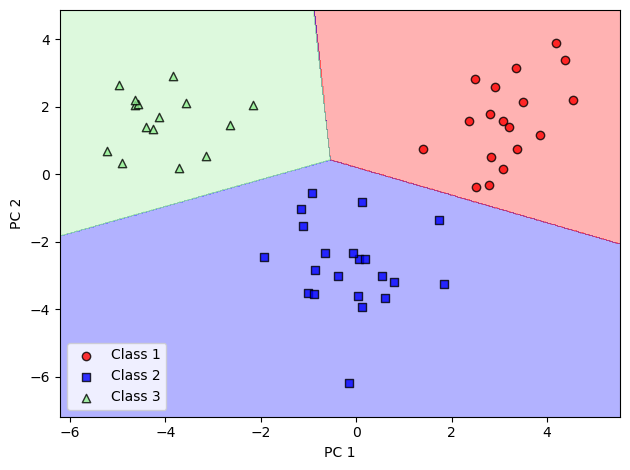

In [23]:
# scikit-learn
# Plotting the decision regions in the reduced space for the test dataset
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()